In [48]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.optimizers import Adam
import random
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 224
image_height = 224
image_size = (image_width, image_height)

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        'data1/train',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
        'data1/validation',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


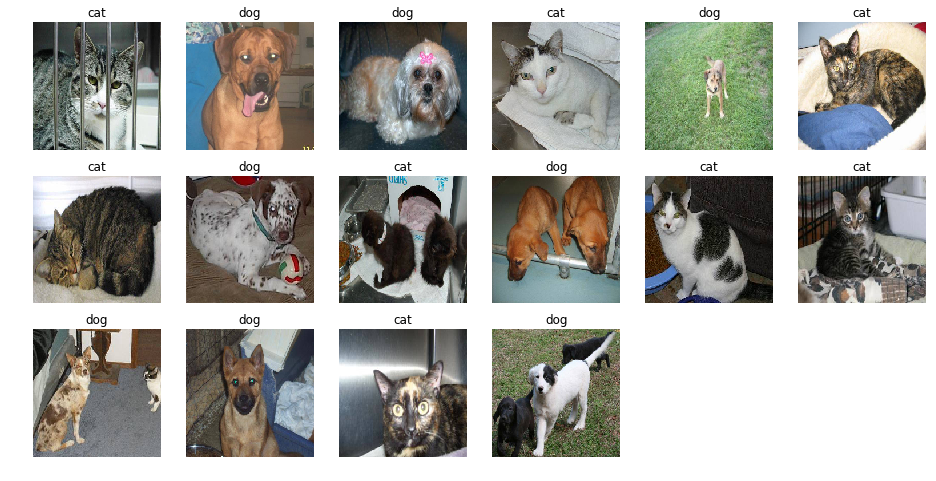

In [4]:
x, y = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

In [7]:
y

array([0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

In [8]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x

In [9]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x

In [11]:
img_input = Input(shape=(image_width, image_height, 3))

x = ZeroPadding2D((3, 3))(img_input)
x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, name='bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

base_model = Model(img_input, x)
base_model.summary()

/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2))`
  after removing the cwd from sys.path.
/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), name="res2a_branch2a", strides=(1, 1))`
  if sys.path[0] == '':
/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="res2a_branch2b", padding="same")`
/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch2c")`
/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `

/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res4e_branch2a")`
  # This is added back by InteractiveShellApp.init_path()
/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="res4e_branch2b", padding="same")`
  app.launch_new_instance()
/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1024, (1, 1), name="res4e_branch2c")`
/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res4f_branch2a")`
  # This is added back by InteractiveShellApp.init_path()
/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:16

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/\
v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        TF_WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        md5_hash='a268eb855778b3df3c7506639542a6af')
base_model.load_weights(weights_path)

In [49]:
x = AveragePooling2D((7, 7), name='avg_pool')(base_model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='output')(x)

model = Model(input=base_model.input, output=x)

/home/root1/Downloads/root@123/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  


In [50]:
top_num = 4
for layer in model.layers[:-top_num]:
    layer.trainable = False

for layer in model.layers[-top_num:]:
    layer.trainable = True

In [51]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
from keras.callbacks import ModelCheckpoint, TensorBoard
best_model = ModelCheckpoint("resnet_best.h5", monitor='val_acc', verbose=0, save_best_only=True)

In [53]:
model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=2,
        callbacks=[best_model, TensorBoard(log_dir='./logs')],
        validation_data=validation_generator
        )

Epoch 1/2


ValueError: Error when checking target: expected output to have shape (2,) but got array with shape (1,)